# Facial Recognition using One-shot Learning

## Deep Learning Assignment 2

### Ben-Gurion University of the Negev

Department of Software and Information Systems Engineering

#**Imports**

In [2]:
!pip install tensorflow numpy opencv-python
import os
import numpy as np
import cv2
from torch import nn
import torch
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import itertools
import torch.optim as optim
import time
import torchvision.transforms as transforms
import matplotlib.image as mpimg
from skimage.color import rgb2gray
!pip install torchmetrics
from torchmetrics import Accuracy



#Check for GPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#Connect to Kaggle

In [4]:
!kaggle datasets download -d jessicali9530/lfw-dataset --unzip -p /sise/home/liorkob/DL/lfw_dataset

# Verify the directory structure
!ls /sise/home/liorkob/DL/lfw_dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 98%|███████████████████████████████████████▏| 110M/112M [00:03<00:00, 41.1MB/s]
100%|████████████████████████████████████████| 112M/112M [00:03<00:00, 32.4MB/s]
lfw_allnames.csv       matchpairsDevTrain.csv	  people.csv
lfw-deepfunneled       mismatchpairsDevTest.csv   peopleDevTest.csv
lfw_readme.csv	       mismatchpairsDevTrain.csv  peopleDevTrain.csv
matchpairsDevTest.csv  pairs.csv


#**Creating and Display Data**

In [5]:
def create_labeled_dataframe(txt_path):
    """
    Reads a text file containing pairs of image names and their labels, then creates a labeled DataFrame.

    Parameters:
    txt_path (str): Path to the text file containing image pairs and labels.

    Returns:
    pd.DataFrame: DataFrame containing image paths and labels for matched (1) and mismatched (0) pairs.
    """
    with open(txt_path, 'r') as file:
        lines = file.readlines()

    matched_pairs = []
    mismatched_pairs = []

    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) == 3:  # Matched pair
            name, imgNum1, imgNum2 = parts
            matched_pairs.append([name, imgNum1, name, imgNum2])
        elif len(parts) == 4:  # Mismatched pair
            name1, imgNum1, name2, imgNum2 = parts
            mismatched_pairs.append([name1, imgNum1, name2, imgNum2])

    match_df = pd.DataFrame(matched_pairs, columns=['name1', 'imgNum1', 'name2', 'imgNum2'])
    mismatch_df = pd.DataFrame(mismatched_pairs, columns=['name1', 'imgNum1', 'name2', 'imgNum2'])

    match_df['label'] = 1
    mismatch_df['label'] = 0

    def create_image_path(name, number):
        """
        Creates the image path for a given name and image number.

        Parameters:
        name (str): Name of the person.
        number (str): Image number.

        Returns:
        str: Full path to the image file.
        """
        return f"{'/sise/home/liorkob/DL/lfw_dataset/lfw-deepfunneled/lfw-deepfunneled'}/{name}/{name}_{str(number).zfill(4)}.jpg"

    match_df['img_path1'] = match_df.apply(lambda row: create_image_path(row['name1'], row['imgNum1']), axis=1)
    match_df['img_path2'] = match_df.apply(lambda row: create_image_path(row['name2'], row['imgNum2']), axis=1)

    mismatch_df['img_path1'] = mismatch_df.apply(lambda row: create_image_path(row['name1'], row['imgNum1']), axis=1)
    mismatch_df['img_path2'] = mismatch_df.apply(lambda row: create_image_path(row['name2'], row['imgNum2']), axis=1)

    match_df = match_df[['img_path1', 'img_path2', 'label']]
    mismatch_df = mismatch_df[['img_path1', 'img_path2', 'label']]

    combined_df = pd.concat([match_df, mismatch_df], ignore_index=True)

    return combined_df

train_df_path= '/sise/home/liorkob/DL/pairsDevTrain.txt'
train_df = create_labeled_dataframe(train_df_path)
test_df_path= '/sise/home/liorkob/DL/pairsDevTest.txt'
test_df = create_labeled_dataframe(test_df_path)



In [6]:
def display_images(image_paths, label):
    """
    Displays a pair of images side by side with a title indicating their label.

    Parameters:
    image_paths (list of str): List containing paths to the two images.
    label (int): Label indicating whether the images are of the same person (1) or different persons (0).
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, path in enumerate(image_paths):
        image = mpimg.imread(path)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(f"Label: {label}", fontsize=16)
    plt.show()

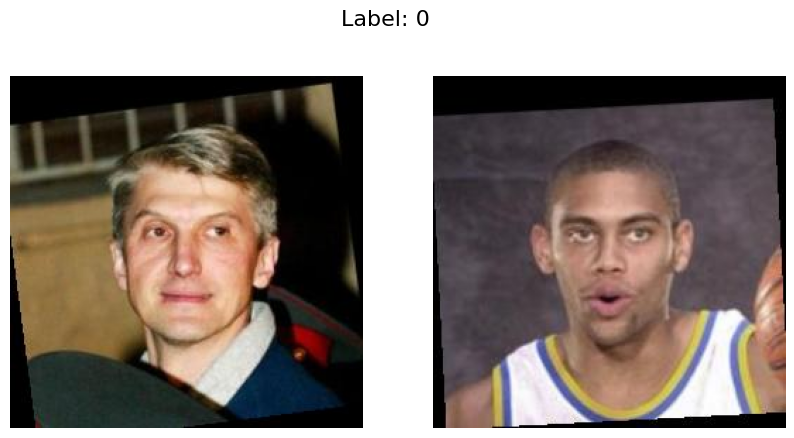

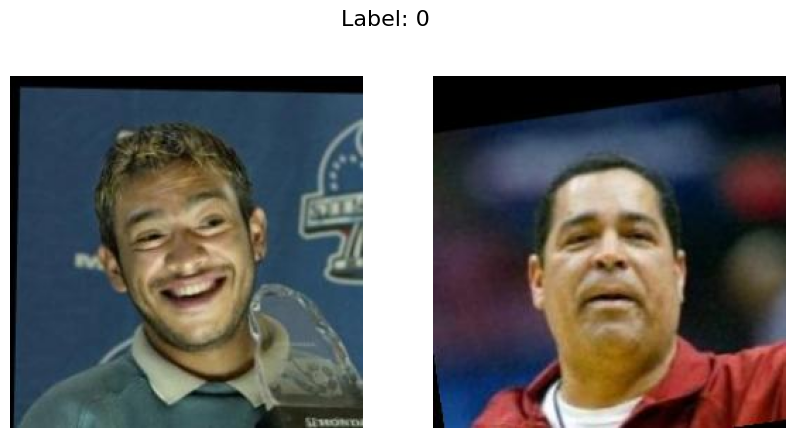

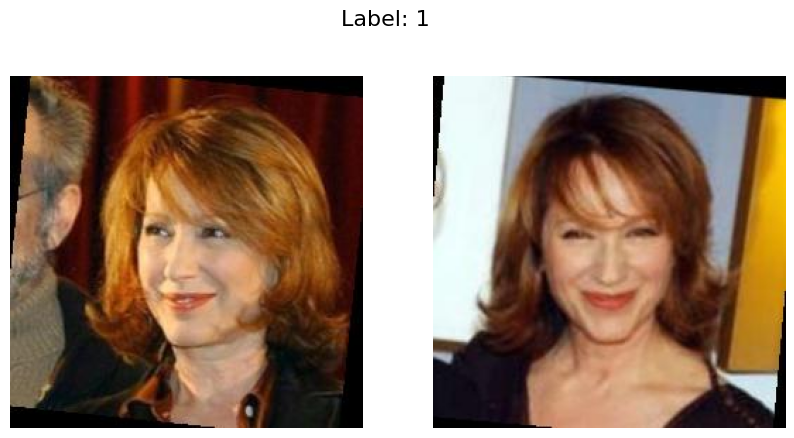

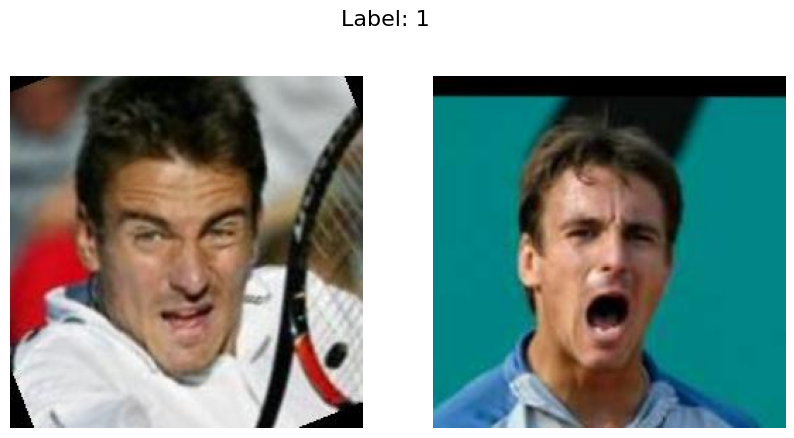

In [7]:
for label in [0, 1]:
    random_indices = train_df[train_df['label'] == label].sample(2, replace=False).index
    for idx in random_indices:
        row = train_df.loc[idx]
        display_images([row['img_path1'], row['img_path2']], row['label'])

#Analyzis


**A histogram is plotted to show the distribution of the number of images per name.**

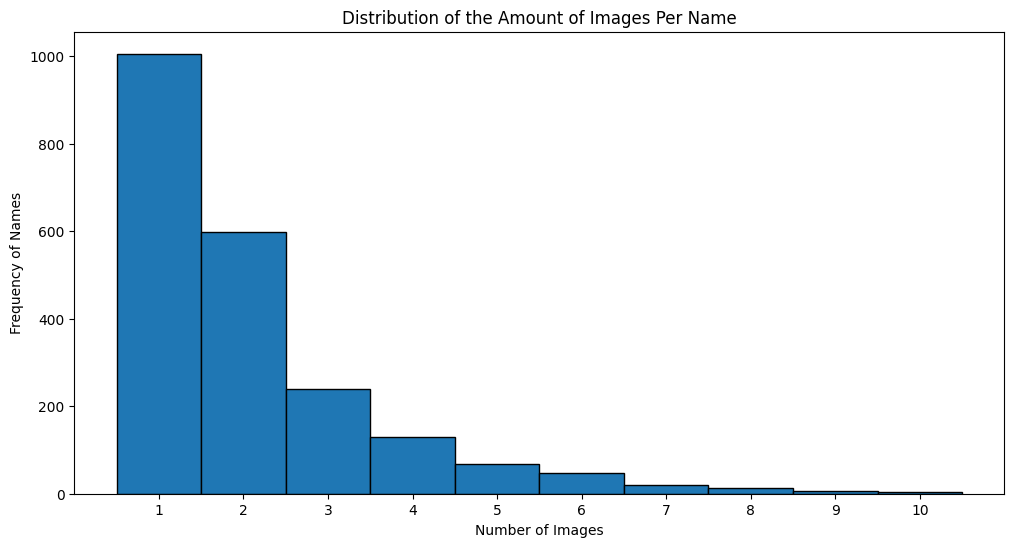

In [7]:
import pandas as  pd
import matplotlib.pyplot as plt

name_counts = pd.concat([
    train_df['img_path1'].apply(lambda x: x.split('/')[-2]),
    train_df['img_path2'].apply(lambda x: x.split('/')[-2])
]).value_counts()

plt.figure(figsize=(12, 6))
bin_edges = np.arange(name_counts.min() - 0.5, name_counts.max() + 1.5, 1)
hist, bins = np.histogram(name_counts, bins=bin_edges)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.bar(bin_centers, hist, width=1, edgecolor='black')
plt.title('Distribution of the Amount of Images Per Name')
plt.xlabel('Number of Images')
plt.ylabel('Frequency of Names')
plt.xticks(bin_centers)
plt.grid(False)
plt.show()



**Plot of Distribution of Matched and Mismatches pairs in Train**

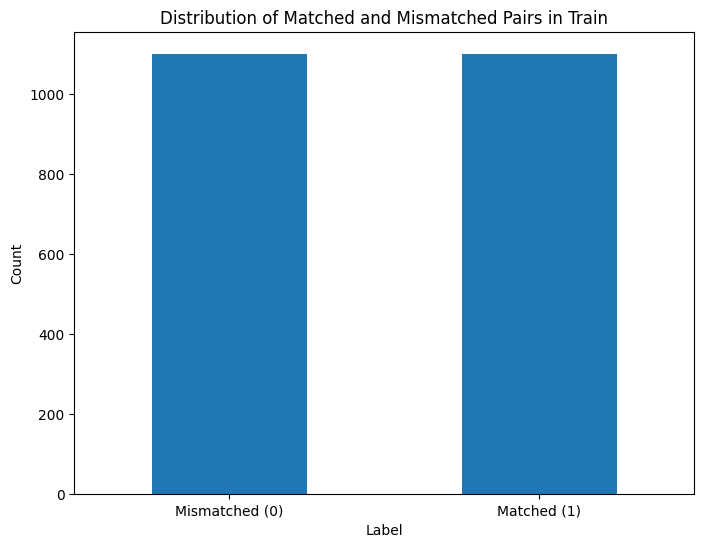

In [8]:
import pandas as pd

plt.figure(figsize=(8, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Matched and Mismatched Pairs in Train')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Mismatched (0)', 'Matched (1)'], rotation=0)
plt.show()


**Plot of Distribution of Matched and Mismatches pairs in Test**

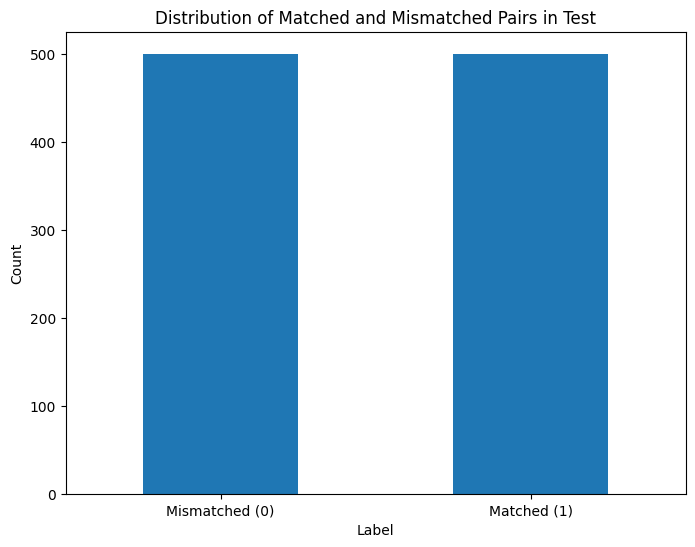

In [9]:
import pandas as pd

plt.figure(figsize=(8, 6))
test_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Matched and Mismatched Pairs in Test')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Mismatched (0)', 'Matched (1)'], rotation=0)
plt.show()


**Displaying the Size and Class Distribution of the Data**

In [10]:

train_size = train_df.shape[0]
test_size = test_df.shape[0]
total_size  = train_size+test_size

total_class_distribution = train_df['label'].value_counts()
train_class_distribution = train_df['label'].value_counts()
test_class_distribution = test_df['label'].value_counts()

report = f"""
Dataset Analysis Report
========================

Total Dataset Size: {total_size} examples

Train Set:
----------
Size: {train_size} examples
Class Distribution:
{train_class_distribution}

Test Set:
---------
Size: {test_size} examples
Class Distribution:
{test_class_distribution}
"""

print(report)


Dataset Analysis Report

Total Dataset Size: 3200 examples

Train Set:
----------
Size: 2200 examples
Class Distribution:
label
1    1100
0    1100
Name: count, dtype: int64

Test Set:
---------
Size: 1000 examples
Class Distribution:
label
1    500
0    500
Name: count, dtype: int64



#Helper Functions

In [8]:
def load_image(image_path, transform=None):
    """
    Loads an image from the specified path and applies the given transformations.

    Parameters:
    image_path (str): Path to the image file.
    transform (callable, optional): Transformations to apply to the image. Defaults to None.

    Returns:
    torch.Tensor: Transformed image tensor.
    """
    image = Image.open(image_path).convert('L')  # Convert to greyscale
    if transform:
        image = transform(image)
    return image

In [9]:
class EarlyStopping:
    """
    Early stopping to terminate training when validation loss does not improve after a given patience.

    Parameters:
    patience (int): Number of epochs with no improvement after which training will be stopped. Defaults to 5.
    min_delta (float): Minimum change in the monitored quantity to qualify as an improvement. Defaults to 0.
    """
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        """
        Check if training should be stopped based on the validation loss.

        Parameters:
        val_loss (float): Current validation loss.

        Returns:
        bool: True if training should be stopped, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

In [10]:
def get_transform(resize=True):
    """
    Get the transformation to be applied to the images.

    Args:
    - resize (bool): Whether to resize the images to 105x105.

    Returns:
    - transform (transforms.Compose): Composed transformation.
    """
    if resize:
        transform = transforms.Compose([
            transforms.Resize((105, 105)),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    return transform

#Siamese Network

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self, use_batchnorm=False, use_dropout=False):
        super(SiameseNetwork, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.BatchNorm2d(64) if self.use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2)if self.use_dropout else nn.Identity()
        )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7),
            nn.BatchNorm2d(128) if self.use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2) if self.use_dropout else nn.Identity()
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4),
            nn.BatchNorm2d(128) if self.use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2) if self.use_dropout else nn.Identity()
        )

        self.cnn4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4),
            nn.BatchNorm2d(256) if self.use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2) if self.use_dropout else nn.Identity()
        )
        # Use adaptive average pooling to ensure the output size is always (6, 6)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc = nn.Sequential(
            nn.Linear(256*6*6, 4096),
            nn.BatchNorm1d(4096) if self.use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if self.use_dropout else nn.Identity(),
            nn.Sigmoid()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

        #Initialization wieghts like in the paper
        self.cnn1[0].weight.data.normal_(0, 0.01)
        self.cnn1[0].bias.data.normal_(0.5, 0.01)
        self.cnn2[0].weight.data.normal_(0, 0.01)
        self.cnn2[0].bias.data.normal_(0.5, 0.01)
        self.cnn3[0].weight.data.normal_(0, 0.01)
        self.cnn3[0].bias.data.normal_(0.5, 0.01)
        self.cnn4[0].weight.data.normal_(0, 0.01)
        self.cnn4[0].bias.data.normal_(0.5, 0.01)
        self.fc[0].weight.data.normal_(0, 0.02)
        self.fc[0].bias.data.normal_(0.5, 0.01)
        self.fc1[0].bias.data.normal_(0.5, 0.01)
        self.fc1[0].weight.data.normal_(0, 0.02)

    def forward_once(self, x):
        """
        Forward pass through the network for one input.

        Parameters:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor after passing through the CNN and fully connected layers.
        """
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.adaptive_pool(x)  # Ensure consistent output size
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


    def forward(self, input1, input2):
        """
        Forward pass for the Siamese Network using Binary Cross-Entropy (BCE) loss.

        This method processes two input images through the network to obtain their
        feature embeddings, computes the absolute difference between the embeddings,
        and then passes this difference through the final fully connected layer to
        produce a similarity score.

        Parameters:
        -----------
        input1 : torch.Tensor
            The first input image tensor with shape (batch_size, channels, height, width).
        input2 : torch.Tensor
            The second input image tensor with the same shape as input1.

        Returns:
        --------
        torch.Tensor
            A tensor containing the similarity scores for each pair of inputs in the batch.
            The scores are values between 0 and 1, indicating the probability that the
            input images are of the same class.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        dist = torch.abs(output1 - output2)
        output = self.fc1(dist)

        return output

#Train Function

In [12]:
def train_one_epoch(net, train_set, batch_size, criterion, optimizer, transform):
    """
    Train the network for one epoch.

    Args:
    - net (torch.nn.Module): The network to train.
    - train_set (pd.DataFrame): Training dataset.
    - batch_size (int): Size of the batch.
    - criterion (torch.nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer.
    - transform (torchvision.transforms.Compose): Transformations to apply.

    Returns:
    - train_loss (float): Training loss for the epoch.
    - train_accuracy (float): Training accuracy for the epoch.
    """
    net.train()
    running_loss = 0.0
    running_accuracy = 0.0
    accuracy_metric = Accuracy(task="binary").cuda().cuda()

    for start in range(0, len(train_set), batch_size):
        end = start + batch_size
        batch = train_set.iloc[start:end]

        img1_batch = torch.stack([load_image(path, transform) for path in batch['img_path1']]).cuda()
        img2_batch = torch.stack([load_image(path, transform) for path in batch['img_path2']]).cuda()
        label_batch = torch.tensor(batch['label'].values, dtype=torch.float32).cuda()

        optimizer.zero_grad()


        output = net.forward(img1_batch, img2_batch)
        label_batch = label_batch.squeeze()
        output = output.squeeze()
        loss = criterion(output, label_batch)
        accuracy_metric.update(output, label_batch.int())


        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / (len(train_set) // batch_size)
    train_accuracy = accuracy_metric.compute().item()
    return train_loss, train_accuracy


In [13]:
def evaluate_one_epoch(net, val_set, batch_size, criterion, transform):
    """
    Evaluate the network for one epoch.

    Args:
    - net (torch.nn.Module): The network to evaluate.
    - val_set (pd.DataFrame): Validation dataset.
    - batch_size (int): Size of the batch.
    - criterion (torch.nn.Module): Loss function.
    - transform (torchvision.transforms.Compose): Transformations to apply.

    Returns:
    - val_loss (float): Validation loss for the epoch.
    - val_accuracy (float): Validation accuracy for the epoch.
    """
    net.eval()
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    accuracy_metric = Accuracy(task="binary").cuda()
    with torch.no_grad():
        for start in range(0, len(val_set), batch_size):
            end = start + batch_size
            batch = val_set.iloc[start:end]

            img1_batch = torch.stack([load_image(path, transform) for path in batch['img_path1']]).cuda()
            img2_batch = torch.stack([load_image(path, transform) for path in batch['img_path2']]).cuda()
            label_batch = torch.tensor(batch['label'].values, dtype=torch.float32).cuda()

            output = net.forward(img1_batch, img2_batch)
            label_batch = label_batch.squeeze()
            output = output.squeeze()
            loss = criterion(output, label_batch)
            accuracy_metric.update(output, label_batch.int())
            val_running_loss += loss.item()

    val_loss = val_running_loss / (len(val_set) // batch_size)
    val_accuracy = accuracy_metric.compute().item()
    return val_loss, val_accuracy


In [14]:
def train_eval(model,train_df, val_size, num_epochs=25, loss_fn_name=nn.BCEWithLogitsLoss, batch_size=32, learning_rate=0.0001, patience=5,resize = True):
    """
    Train and evaluate the Siamese Network model.

    Args:
    - train_df (pd.DataFrame): DataFrame containing the training data.
    - val_size (float): Fraction of the training data to be used as validation data.
    - num_epochs (int): Number of epochs to train.
    - loss_fn_name (torch.nn.Module): Loss function class.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for the optimizer.
    - patience (int): Patience for early stopping.

    Returns:
    - final_train_loss (float): Final training loss.
    - final_val_loss (float): Final validation loss.
    - final_train_accuracy (float): Final training accuracy.
    - final_val_accuracy (float): Final validation accuracy.
    - duration (float): Total training duration.
    """
    start_time = time.time()
    train_set, val_set = train_test_split(train_df, test_size=val_size, random_state=42)
    net = model.cuda()
    criterion = loss_fn_name()

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=patience)
    transform = get_transform(resize=resize)


    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(net, train_set, batch_size, criterion, optimizer, transform)
        val_loss, val_accuracy = evaluate_one_epoch(net, val_set, batch_size, criterion, transform)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if early_stopping.step(val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

    end_time = time.time()
    duration = end_time - start_time

    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    final_train_accuracy = train_accuracies[-1]
    final_val_accuracy = val_accuracies[-1]

    # Plotting
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, duration


#Train First Model With Resize

Epoch [1/20], Train Loss: 0.7138, Validation Loss: 0.7344
Train Loss: 0.7138, Validation Loss: 0.7344
Epoch [2/20], Train Loss: 0.6880, Validation Loss: 0.7337
Train Loss: 0.6880, Validation Loss: 0.7337
Epoch [3/20], Train Loss: 0.6843, Validation Loss: 0.7307
Train Loss: 0.6843, Validation Loss: 0.7307
Epoch [4/20], Train Loss: 0.6817, Validation Loss: 0.7283
Train Loss: 0.6817, Validation Loss: 0.7283
Epoch [5/20], Train Loss: 0.6786, Validation Loss: 0.7283
Train Loss: 0.6786, Validation Loss: 0.7283
Epoch [6/20], Train Loss: 0.6762, Validation Loss: 0.7222
Train Loss: 0.6762, Validation Loss: 0.7222
Epoch [7/20], Train Loss: 0.6711, Validation Loss: 0.7209
Train Loss: 0.6711, Validation Loss: 0.7209
Epoch [8/20], Train Loss: 0.6671, Validation Loss: 0.7186
Train Loss: 0.6671, Validation Loss: 0.7186
Epoch [9/20], Train Loss: 0.6623, Validation Loss: 0.7164
Train Loss: 0.6623, Validation Loss: 0.7164
Epoch [10/20], Train Loss: 0.6573, Validation Loss: 0.7113
Train Loss: 0.6573, Val

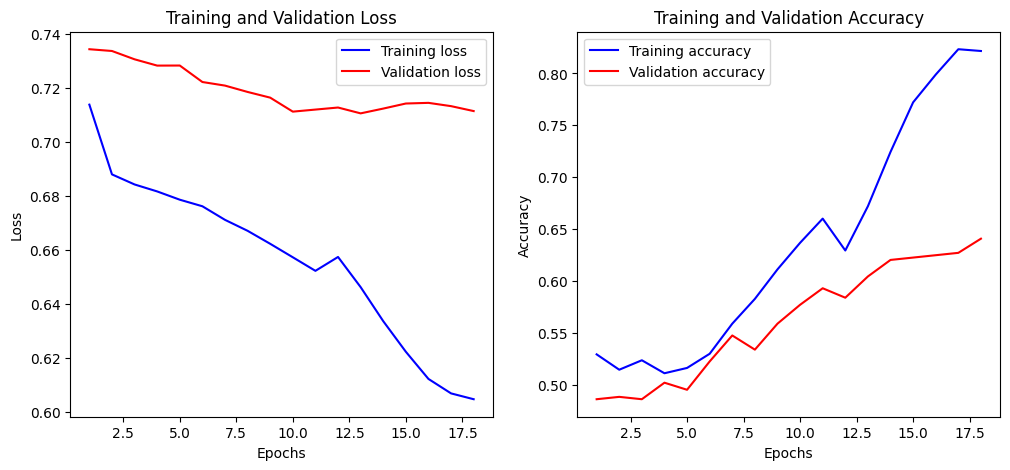

Final Results:
Train Loss: 0.6046, Validation Loss: 0.7115
Train Accuracy: 0.8216, Validation Accuracy: 0.6409
Total Training Time: 153.47 seconds
num_epochs=20, batch_size=32, lr=0.0001


In [29]:
val_size=0.2
num_epochs=20
loss_fn_name=nn.BCEWithLogitsLoss
batch_size=32
learning_rate=0.0001
model = SiameseNetwork()

final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, duration = train_eval(model,train_df, val_size, num_epochs, loss_fn_name, batch_size, learning_rate, patience=5)

print(f"Final Results:")
print(f"Train Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_accuracy:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Total Training Time: {duration:.2f} seconds")
print(f"num_epochs={num_epochs}, batch_size={batch_size}, lr={learning_rate}")


#Train First Model Without Resize

Epoch [1/20], Train Loss: 0.7059, Validation Loss: 0.7329
Train Loss: 0.7059, Validation Loss: 0.7329
Epoch [2/20], Train Loss: 0.6825, Validation Loss: 0.7280
Train Loss: 0.6825, Validation Loss: 0.7280
Epoch [3/20], Train Loss: 0.6770, Validation Loss: 0.7227
Train Loss: 0.6770, Validation Loss: 0.7227
Epoch [4/20], Train Loss: 0.6718, Validation Loss: 0.7208
Train Loss: 0.6718, Validation Loss: 0.7208
Epoch [5/20], Train Loss: 0.6683, Validation Loss: 0.7179
Train Loss: 0.6683, Validation Loss: 0.7179
Epoch [6/20], Train Loss: 0.6647, Validation Loss: 0.7206
Train Loss: 0.6647, Validation Loss: 0.7206
Epoch [7/20], Train Loss: 0.6646, Validation Loss: 0.7200
Train Loss: 0.6646, Validation Loss: 0.7200
Epoch [8/20], Train Loss: 0.6634, Validation Loss: 0.7218
Train Loss: 0.6634, Validation Loss: 0.7218
Epoch [9/20], Train Loss: 0.6624, Validation Loss: 0.7173
Train Loss: 0.6624, Validation Loss: 0.7173
Epoch [10/20], Train Loss: 0.6584, Validation Loss: 0.7121
Train Loss: 0.6584, Val

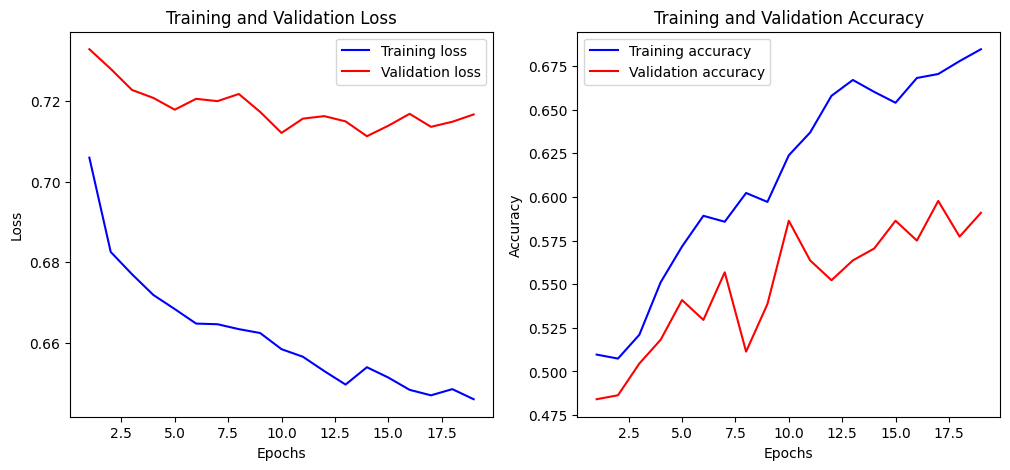

Final Results:
Train Loss: 0.6460, Validation Loss: 0.7167
Train Accuracy: 0.6847, Validation Accuracy: 0.5909
Total Training Time: 399.81 seconds
num_epochs=20, batch_size=32, lr=0.0001


In [30]:
val_size=0.2
num_epochs=20
loss_fn_name=nn.BCEWithLogitsLoss
batch_size=32
learning_rate=0.0001
model = SiameseNetwork()

final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, duration = train_eval(model,train_df, val_size, num_epochs, loss_fn_name, batch_size, learning_rate, patience=5,resize=False)

print(f"Final Results:")
print(f"Train Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_accuracy:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Total Training Time: {duration:.2f} seconds")
print(f"num_epochs={num_epochs}, batch_size={batch_size}, lr={learning_rate}")


#Train Second Model - With Batchnorm & Without Dropout


Epoch [1/20], Train Loss: 0.7043, Validation Loss: 0.7294
Train Loss: 0.7043, Validation Loss: 0.7294
Epoch [2/20], Train Loss: 0.6527, Validation Loss: 0.7162
Train Loss: 0.6527, Validation Loss: 0.7162
Epoch [3/20], Train Loss: 0.6165, Validation Loss: 0.7139
Train Loss: 0.6165, Validation Loss: 0.7139
Epoch [4/20], Train Loss: 0.5889, Validation Loss: 0.7124
Train Loss: 0.5889, Validation Loss: 0.7124
Epoch [5/20], Train Loss: 0.5690, Validation Loss: 0.7098
Train Loss: 0.5690, Validation Loss: 0.7098
Epoch [6/20], Train Loss: 0.5507, Validation Loss: 0.7078
Train Loss: 0.5507, Validation Loss: 0.7078
Epoch [7/20], Train Loss: 0.5354, Validation Loss: 0.7072
Train Loss: 0.5354, Validation Loss: 0.7072
Epoch [8/20], Train Loss: 0.5261, Validation Loss: 0.7116
Train Loss: 0.5261, Validation Loss: 0.7116
Epoch [9/20], Train Loss: 0.5195, Validation Loss: 0.7141
Train Loss: 0.5195, Validation Loss: 0.7141
Epoch [10/20], Train Loss: 0.5155, Validation Loss: 0.7038
Train Loss: 0.5155, Val

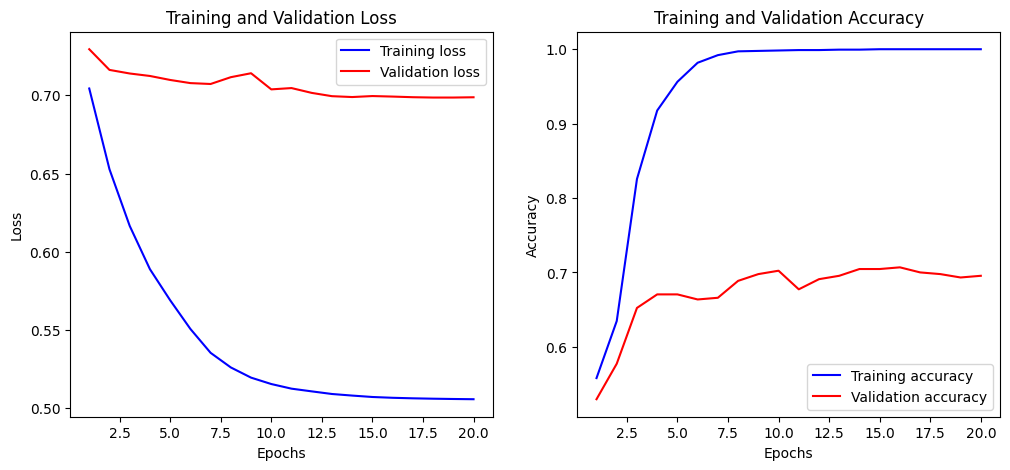

Final Results:
Train Loss: 0.5057, Validation Loss: 0.6987
Train Accuracy: 1.0000, Validation Accuracy: 0.6955
Total Training Time: 170.10 seconds
num_epochs=20, batch_size=32, lr=0.0001


In [42]:
val_size=0.2
num_epochs=20
loss_fn_name=nn.BCEWithLogitsLoss
batch_size=32
learning_rate=0.0001
model = SiameseNetwork(use_batchnorm=True)

final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, duration = train_eval(model,train_df, val_size, num_epochs, loss_fn_name, batch_size, learning_rate, patience=5)

model_save_path = 'siamese_model.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Final Results:")
print(f"Train Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_accuracy:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Total Training Time: {duration:.2f} seconds")
print(f"num_epochs={num_epochs}, batch_size={batch_size}, lr={learning_rate}")


#Train Third Model - Without Batchnorm & With Dropout

Epoch [1/20], Train Loss: 0.6944, Validation Loss: 0.7860
Train Loss: 0.6944, Validation Loss: 0.7860
Epoch [2/20], Train Loss: 0.6933, Validation Loss: 0.7860
Train Loss: 0.6933, Validation Loss: 0.7860
Epoch [3/20], Train Loss: 0.6933, Validation Loss: 0.7860
Train Loss: 0.6933, Validation Loss: 0.7860
Epoch [4/20], Train Loss: 0.6934, Validation Loss: 0.7860
Train Loss: 0.6934, Validation Loss: 0.7860
Epoch [5/20], Train Loss: 0.6932, Validation Loss: 0.7860
Train Loss: 0.6932, Validation Loss: 0.7860
Epoch [6/20], Train Loss: 0.6933, Validation Loss: 0.7860
Train Loss: 0.6933, Validation Loss: 0.7860
Epoch [7/20], Train Loss: 0.6932, Validation Loss: 0.7860
Train Loss: 0.6932, Validation Loss: 0.7860
Epoch [8/20], Train Loss: 0.6932, Validation Loss: 0.7860
Train Loss: 0.6932, Validation Loss: 0.7860
Epoch [9/20], Train Loss: 0.6932, Validation Loss: 0.7860
Train Loss: 0.6932, Validation Loss: 0.7860
Epoch [10/20], Train Loss: 0.6932, Validation Loss: 0.7860
Train Loss: 0.6932, Val

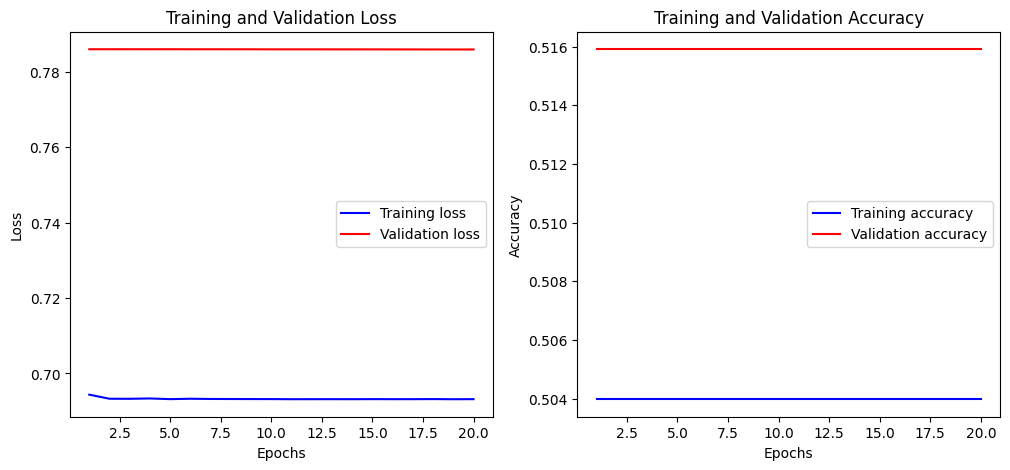

Final Results:
Train Loss: 0.6932, Validation Loss: 0.7859
Train Accuracy: 0.5040, Validation Accuracy: 0.5159
Total Training Time: 180.85 seconds
num_epochs=20, batch_size=32, lr=0.0001


In [39]:
val_size=0.2
num_epochs=20
loss_fn_name=nn.BCEWithLogitsLoss
batch_size=32
learning_rate=0.0001
model = model = SiameseNetwork(use_dropout=True)

final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, duration = train_eval(model,train_df, val_size, num_epochs, loss_fn_name, batch_size, learning_rate, patience=5)

print(f"Final Results:")
print(f"Train Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_accuracy:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Total Training Time: {duration:.2f} seconds")
print(f"num_epochs={num_epochs}, batch_size={batch_size}, lr={learning_rate}")


###Train Fourth Model - With Batchnorm & With Dropout

Epoch [1/20], Train Loss: 0.7203, Validation Loss: 0.7521
Train Loss: 0.7203, Validation Loss: 0.7521
Epoch [2/20], Train Loss: 0.6936, Validation Loss: 0.7426
Train Loss: 0.6936, Validation Loss: 0.7426
Epoch [3/20], Train Loss: 0.6867, Validation Loss: 0.7386
Train Loss: 0.6867, Validation Loss: 0.7386
Epoch [4/20], Train Loss: 0.6828, Validation Loss: 0.7372
Train Loss: 0.6828, Validation Loss: 0.7372
Epoch [5/20], Train Loss: 0.6776, Validation Loss: 0.7355
Train Loss: 0.6776, Validation Loss: 0.7355
Epoch [6/20], Train Loss: 0.6735, Validation Loss: 0.7314
Train Loss: 0.6735, Validation Loss: 0.7314
Epoch [7/20], Train Loss: 0.6702, Validation Loss: 0.7300
Train Loss: 0.6702, Validation Loss: 0.7300
Epoch [8/20], Train Loss: 0.6664, Validation Loss: 0.7273
Train Loss: 0.6664, Validation Loss: 0.7273
Epoch [9/20], Train Loss: 0.6619, Validation Loss: 0.7289
Train Loss: 0.6619, Validation Loss: 0.7289
Epoch [10/20], Train Loss: 0.6576, Validation Loss: 0.7267
Train Loss: 0.6576, Val

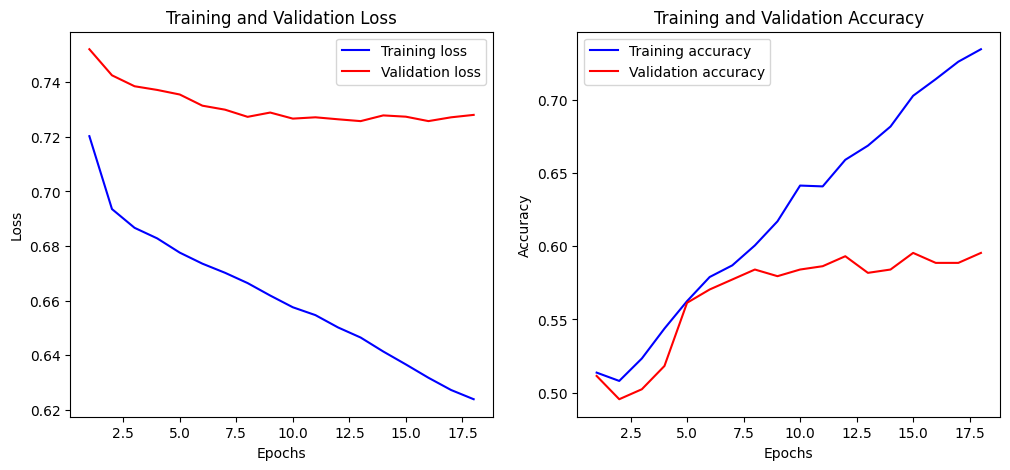

Final Results:
Train Loss: 0.6239, Validation Loss: 0.7281
Train Accuracy: 0.7347, Validation Accuracy: 0.5955
Total Training Time: 151.47 seconds
num_epochs=20, batch_size=32, lr=0.0001


In [45]:
val_size=0.2
num_epochs=20
loss_fn_name=nn.BCEWithLogitsLoss
batch_size=32
learning_rate=0.0001
model = model = SiameseNetwork(use_batchnorm=True,use_dropout=True)

final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, duration = train_eval(model,train_df, val_size, num_epochs, loss_fn_name, batch_size, learning_rate, patience=5)

print(f"Final Results:")
print(f"Train Loss: {final_train_loss:.4f}, Validation Loss: {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_accuracy:.4f}, Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Total Training Time: {duration:.2f} seconds")
print(f"num_epochs={num_epochs}, batch_size={batch_size}, lr={learning_rate}")


#Experiments With Grid

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )

        self.cnn4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Sequential(
            nn.Linear(256*6*6, 4096),
            nn.Sigmoid()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid())

        # Weight initialization as in the paper
        self.cnn1[0].weight.data.normal_(0, 0.01)
        self.cnn1[0].bias.data.normal_(0.5, 0.01)

        self.cnn2[0].weight.data.normal_(0, 0.01)
        self.cnn2[0].bias.data.normal_(0.5, 0.01)

        self.cnn3[0].weight.data.normal_(0, 0.01)
        self.cnn3[0].bias.data.normal_(0.5, 0.01)

        self.cnn4[0].weight.data.normal_(0, 0.01)
        self.cnn4[0].bias.data.normal_(0.5, 0.01)

        self.fc[0].weight.data.normal_(0, 0.02)
        self.fc[0].bias.data.normal_(0.5, 0.01)

        self.fc1[0].bias.data.normal_(0.5, 0.01)
        self.fc1[0].weight.data.normal_(0, 0.02)

    def forward_once(self, x):
        """
        Forward pass through the network for one input.

        Parameters:
        x (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor after passing through the CNN and fully connected layers.
        """
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward_ContrastiveLoss(self, input1, input2):
        """
        Forward pass through the network for a pair of inputs.

        Parameters:
        input1 (torch.Tensor): First input tensor.
        input2 (torch.Tensor): Second input tensor.

        Returns:
        tuple: Two output tensors after passing each input through the network.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def forward_bce(self, input1, input2):
        """
        Forward pass for the Siamese Network using Binary Cross-Entropy (BCE) loss.

        This method processes two input images through the network to obtain their
        feature embeddings, computes the absolute difference between the embeddings,
        and then passes this difference through the final fully connected layer to
        produce a similarity score.

        Parameters:
        -----------
        input1 : torch.Tensor
            The first input image tensor with shape (batch_size, channels, height, width).
        input2 : torch.Tensor
            The second input image tensor with the same shape as input1.

        Returns:
        --------
        torch.Tensor
            A tensor containing the similarity scores for each pair of inputs in the batch.
            The scores are values between 0 and 1, indicating the probability that the
            input images are of the same class.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        dist = torch.abs(output1 - output2)
        output = self.fc1(dist)

        return output


In [ ]:
def train_eval(train_df, val_size, num_epochs=25, loss_fn_name=ContrastiveLoss, batch_size=32, learning_rate=0.0001, patience=5):
    start_time = time.time()
    train_set, val_set = train_test_split(train_df, test_size=val_size, random_state=42)
    net = SiameseNetwork().cuda()
    criterion = loss_fn_name()

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=patience)

    transform = transforms.Compose([
        transforms.Resize((105, 105)),
        transforms.ToTensor(),
    ])

    # Initialize accuracy metric
    accuracy_metric = Accuracy(task="binary").cuda()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        total_train_accuracy = 0.0
        total_train_samples = 0

        for start in range(0, len(train_set), batch_size):
            end = start + batch_size
            batch = train_set.iloc[start:end]

            img1_batch = torch.stack([transform(Image.open(path).convert('L')) for path in batch['img_path1']]).cuda()
            img2_batch = torch.stack([transform(Image.open(path).convert('L')) for path in batch['img_path2']]).cuda()
            label_batch = torch.tensor(batch['label'].values, dtype=torch.float32).cuda()

            optimizer.zero_grad()

            if isinstance(criterion, nn.BCEWithLogitsLoss):
                output = net.forward_bce(img1_batch, img2_batch)
                label_batch = label_batch.squeeze()
                output = output.squeeze()
                loss = criterion(output, label_batch)
                accuracy = accuracy_metric(output, label_batch).item()
            else:
                output1, output2 = net.forward_ContrastiveLoss(img1_batch, img2_batch)
                loss = criterion(output1, output2, label_batch)
                euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
                predictions = (euclidean_distance < 0.5).float()
                accuracy = accuracy_metric(predictions, label_batch).item()

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_train_accuracy += accuracy * label_batch.size(0)
            total_train_samples += label_batch.size(0)

        train_loss = running_loss / (len(train_set) // batch_size)
        train_accuracy = total_train_accuracy / total_train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation step
        net.eval()
        val_running_loss = 0.0
        total_val_accuracy = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for start in range(0, len(val_set), batch_size):
                end = start + batch_size
                batch = val_set.iloc[start:end]

                img1_batch = torch.stack([transform(Image.open(path).convert('L')) for path in batch['img_path1']]).cuda()
                img2_batch = torch.stack([transform(Image.open(path).convert('L')) for path in batch['img_path2']]).cuda()
                label_batch = torch.tensor(batch['label'].values, dtype=torch.float32).cuda()

                if isinstance(criterion, nn.BCEWithLogitsLoss):
                    output = net.forward_bce(img1_batch, img2_batch)
                    label_batch = label_batch.squeeze()
                    output = output.squeeze()
                    loss = criterion(output, label_batch)
                    accuracy = accuracy_metric(output, label_batch).item()
                else:
                    output1, output2 = net.forward_ContrastiveLoss(img1_batch, img2_batch)
                    loss = criterion(output1, output2, label_batch)
                    euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
                    predictions = (euclidean_distance < 0.5).float()
                    accuracy = accuracy_metric(predictions, label_batch).item()

                val_running_loss += loss.item()
                total_val_accuracy += accuracy * label_batch.size(0)
                total_val_samples += label_batch.size(0)

        val_loss = val_running_loss / (len(val_set) // batch_size)
        val_accuracy = total_val_accuracy / total_val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if early_stopping.step(val_loss):
            print(f"Early stopping at epoch {epoch+1}")
            break

    duration = time.time() - start_time

    return train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1], duration


In [ ]:

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.

    This loss encourages the network to output embeddings that are closer together for similar pairs
    and farther apart for dissimilar pairs.

    Parameters:
    margin (float): Margin for contrastive loss. Defaults to 2.0.
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Computes the contrastive loss.

        Parameters:
        output1 (torch.Tensor): Embedding of the first image.
        output2 (torch.Tensor): Embedding of the second image.
        label (torch.Tensor): Binary label indicating if the images are of the same person (1) or different persons (0).

        Returns:
        torch.Tensor: Computed contrastive loss.
        """
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor(),
])


In [ ]:

def grid_search(train_df, optimizers, loss_functions, epochs, batch_sizes, learning_rates, val_size=0.2, patience=5):
    """
    Perform grid search to find the best hyperparameters.

    Args:
    - train_df: DataFrame containing the training data.
    - optimizers: List of optimizer functions.
    - loss_functions: List of loss functions.
    - epochs: List of epoch values.
    - batch_sizes: List of batch size values.
    - learning_rates: List of learning rate values.
    - val_size: Fraction of the training data to be used as validation data.
    - patience: Patience for early stopping.

    Returns:
    - results: List of dictionaries containing the results for each hyperparameter combination.
    """
    results = []
    iter_num = 1

    for optimizer_fn in optimizers:
        for loss_fn in loss_functions:
            for epoch in epochs:
                for batch_size in batch_sizes:
                    for lr in learning_rates:
                        print(f"Running experiment with optimizer={optimizer_fn.__name__}, loss_fn={loss_fn.__name__}, epochs={epoch}, batch_size={batch_size}, learning_rate={lr}")

                        start_time = time.time()

                        final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, duration = train_eval(
                            train_df, val_size, epoch,loss_fn, batch_size, lr, patience
                        )

                        convergence_time = time.time() - start_time

                        print('---------------------------------------------------------------')
                        print(f"Test number: {iter_num}, optimizer: {optimizer_fn.__name__}, loss_fn: {loss_fn.__name__}, epochs: {epoch}, batch_size: {batch_size}, lr: {lr}")
                        print(f'Convergence time: {convergence_time}')
                        print(f'Train accuracy: {final_train_accuracy}')
                        print(f'Validation accuracy: {final_val_accuracy}')
                        print('---------------------------------------------------------------')

                        results.append({
                            'test_number': iter_num,
                            'optimizer': optimizer_fn.__name__,
                            'loss_fn': loss_fn.__name__,
                            'epochs': epoch,
                            'batch_size': batch_size,
                            'learning_rate': lr,
                            'convergence_time': convergence_time,
                            'final_train_accuracy': final_train_accuracy,
                            'final_val_accuracy': final_val_accuracy,
                        })

                        iter_num += 1

    return results

In [ ]:

optimizers = [optim.Adam, optim.SGD]
loss_functions = [nn.BCEWithLogitsLoss,ContrastiveLoss]
epochs = [20,25]
batch_size = [16, 32, 64]
learning_rates = [0.001, 0.0001]

results = grid_search(train_df, optimizers, loss_functions, epochs, batch_size, learning_rates)

for result in results:
    print(f"Test number: {result['test_number']}, optimizer: {result['optimizer']}, loss_fn: {result['loss_fn']}, epochs: {result['epochs']}, batch_size: {result['batch_size']}, lr: {result['learning_rate']}")
    print(f"Convergence time: {result['convergence_time']}")
    print(f"Train accuracy: {result['final_train_accuracy']}")
    print(f"Validation accuracy: {result['final_val_accuracy']}")
    print('---------------------------------------------------------------')


#Test

In [15]:
# Load the trained model
model = SiameseNetwork(use_batchnorm=True)
model_load_path = 'siamese_model.pth'
model.load_state_dict(torch.load(model_load_path))
model.to(device)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Identity()
  )
  (cnn2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Identity()
  )
  (cnn3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Identity()
  )
  (cnn4): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [18]:
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(net, test_data, batch_size, criterion, resize=True):
    start_time = time.time()

    net.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_running_accuracy = 0.0
    accuracy_metric = Accuracy(task="binary").cuda()
    transform = get_transform(resize=resize)

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for start in range(0, len(test_data), batch_size):
            end = start + batch_size
            batch = test_data.iloc[start:end]
            img1_batch = torch.stack([load_image(path, transform) for path in batch['img_path1']]).cuda()
            img2_batch = torch.stack([load_image(path, transform) for path in batch['img_path2']]).cuda()
            label_batch = torch.tensor(batch['label'].values, dtype=torch.float32).cuda()

            output = net(img1_batch, img2_batch).squeeze()
            label_batch = label_batch.squeeze()
            loss = criterion(output, label_batch)
            accuracy = accuracy_metric(output, label_batch.int())

            test_running_loss += loss.item()
            test_running_accuracy += accuracy.item()

        # Finalize loss and accuracy
        test_loss = test_running_loss / (len(test_data) // batch_size)
        test_accuracy = test_running_accuracy / (len(test_data) // batch_size)
    end_time = time.time()
    duration = end_time - start_time


    return test_loss, test_accuracy,duration


In [19]:
criterion = nn.BCEWithLogitsLoss()
batch_size = 32

test_loss, test_accuracy,duration = evaluate_model_on_test_set(model, test_df, batch_size, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, , Test duration: {duration:.4f}")


Test Loss: 0.6949, Test Accuracy: 0.7026, , Test duration: 3.3241


In [82]:
# Define the transformation to resize the image and convert it to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((105, 105)),
    transforms.ToTensor()
])

def load_image(image_path):
    """
    Load an image from the given path and apply transformations.

    Parameters:
    image_path (str): Path to the image file.

    Returns:
    torch.Tensor: Transformed image tensor.
    """
    image = Image.open(image_path)
    image = transform(image)
    return image.unsqueeze(0)

def predict(img1, img2, model):
    """
    Predict the label for a pair of images using a given model.

    Args:
    - img1 (torch.Tensor): The first image tensor.
    - img2 (torch.Tensor): The second image tensor.
    - model (torch.nn.Module): The PyTorch model used for prediction.

    Returns:
    - tuple: A tuple containing:
        - float: The predicted label for the image pair.
        - float: The probability output by the model for the image pair.
    """
    img1 = img1.to(device)
    img2 = img2.to(device)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        prob = model(img1, img2)
        pred_label = prob.round()
        prob = prob.item()
    # Define confidence based on the predicted label
    if pred_label == 1:
        confidence = prob  # Confidence in 'same category'
    else:
        confidence = 1 - prob  # Confidence in 'different category'

    return pred_label.item(), confidence

correct_predictions = []
misclassified_predictions = []
correct_count = 0
misclassified_count = 0

# Iterate over the test DataFrame
for idx in range(len(test_df)):
    img1_path = test_df.iloc[idx]['img_path1']
    img2_path = test_df.iloc[idx]['img_path2']
    label = test_df.iloc[idx]['label']

    # Load and transform the images
    img1 = load_image(img1_path)
    img2 = load_image(img2_path)

    # Predict
    pred_label, prob = predict(img1, img2, model)

    # Check if the prediction is correct
    is_correct = pred_label == label

    if is_correct:
        correct_predictions.append((idx, pred_label, prob))  # Save index, predicted label, and probability
        correct_count += 1
    else:
        misclassified_predictions.append((idx, pred_label, prob))  # Save index, predicted label, and probability
        misclassified_count += 1


In [72]:

import matplotlib.pyplot as plt
import random

def display_images(predictions, title):
    """
    Displays pairs of images side by side with a title indicating their label and probability,
    aiming to display one example for each label (0 and 1) if available.

    Parameters:
    predictions (list): List of tuples containing (index, predicted_label, probability).
    title (str): Main title for the plot.
    """
    random.shuffle(predictions)

    # Filter predictions to get one of each label
    example_per_label = {}
    for idx, pred_label, confidence in predictions:
        if pred_label not in example_per_label:
            example_per_label[pred_label] = (idx, pred_label, confidence)
            if len(example_per_label) == 2:
                break  # Stop once we have one example per label (0 and 1)

    if not example_per_label:
        print("No suitable examples found to display.")
        return


    for idx, pred_label, confidence in example_per_label.values():
        img1_path = test_df.iloc[idx]['img_path1']
        img2_path = test_df.iloc[idx]['img_path2']

        img1 = load_image(img1_path).squeeze().cpu().numpy()
        img2 = load_image(img2_path).squeeze().cpu().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img1, cmap='gray')
        axes[0].axis('off')
        axes[1].imshow(img2, cmap='gray')
        axes[1].axis('off')

        fig.suptitle(f"Label: {pred_label}, confidence: {confidence:.4f}", fontsize=16)
        plt.show()



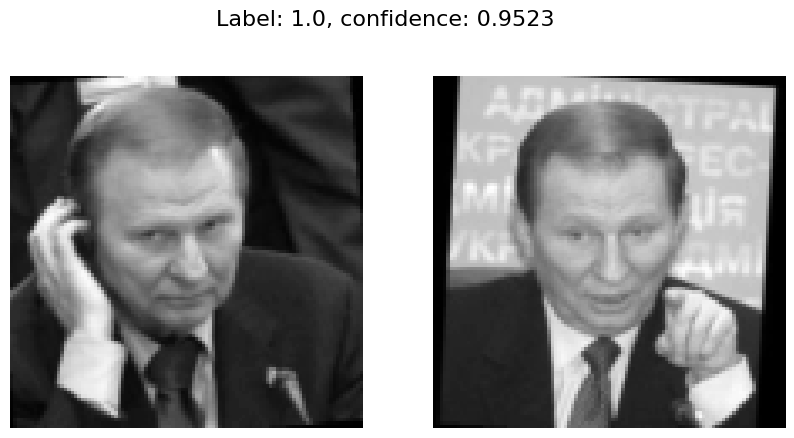

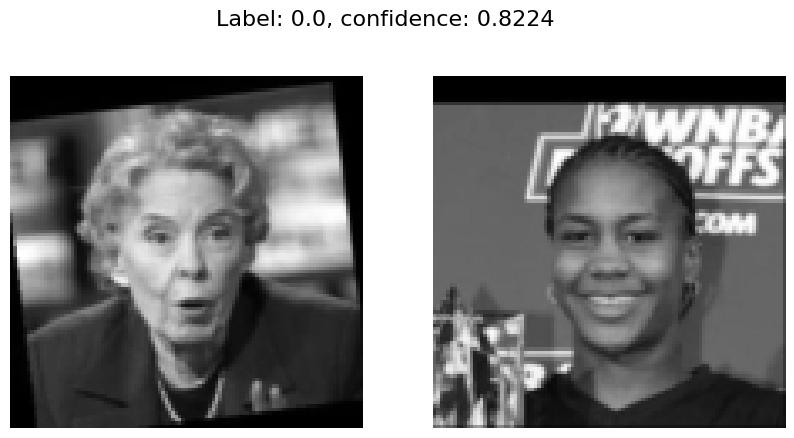

In [75]:
# Display only the first two correct predictions
display_images(correct_predictions, title='Correct Predictions')

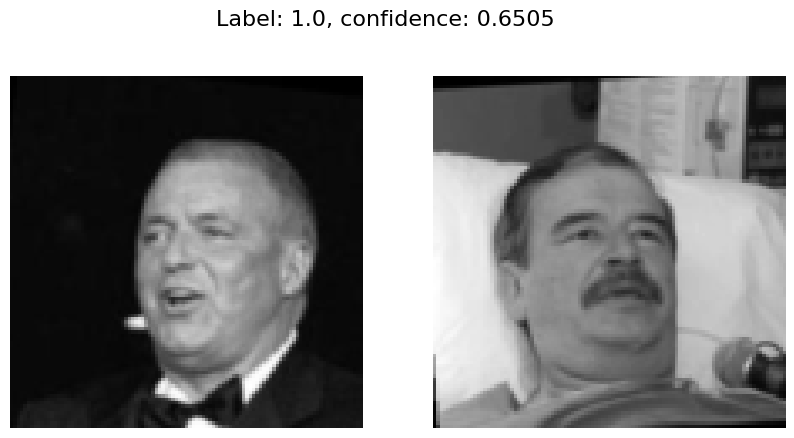

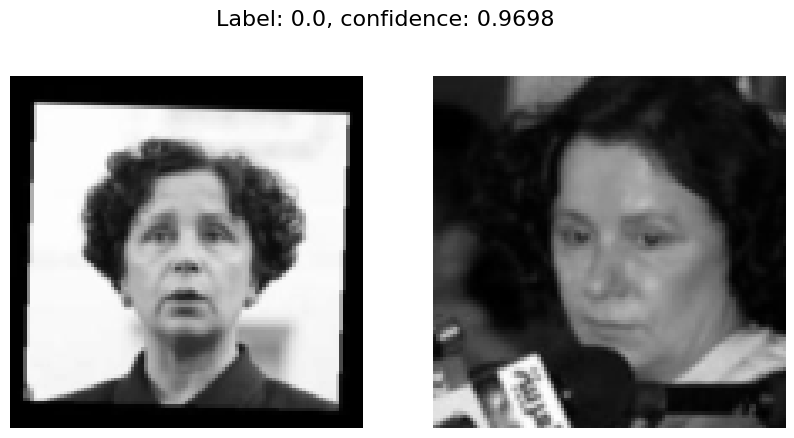

In [77]:
# Display only the first two misclassified predictions
display_images(misclassified_predictions, title='Misclassified Predictions')